In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
# import seaborn as sns
from math import ceil
from sklearn.decomposition import PCA, FastICA

In [2]:
size = 256
n_im = 45
images = np.empty((n_im, size, size))
for i in range(n_im):
    images[i] = np.genfromtxt('ruderman/image_{}.txt'.format(1+i))
#     images[i] = np.log(images[i]) #already log-transformed
#     images[i] = images[i] - np.mean(images[i])

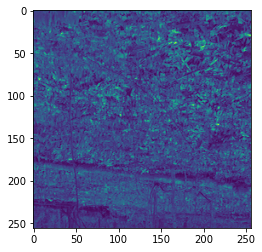

In [3]:
plt.imshow(images[10])

In [4]:
# image = images[0]

### Extract patches

In [5]:
def sample_patches(n_points, d, an_image, seed = 10):
    np.random.seed(seed)
    xs = np.random.choice(np.arange(d,size), n_points, replace = True)
    ys = np.random.choice(np.arange(d,size), n_points, replace = True)
    patches = np.empty((n_points, d*d))
    for p in range(n_points):
        patches[p] = square(xs[p], ys[p], d, an_image)
    return patches

In [6]:
def square(cx, cy, d, an_image):
    mask = np.zeros_like(an_image)
    mask[cx-d:cx, cy-d:cy] = 1
    return an_image[np.where(mask == True)]

In [7]:
n_points = 250
X = []
d = 7
for i in range(n_im):
    image = images[0]
    X.append(sample_patches(n_points, d, image))
X = np.reshape(np.array(X), (n_im*n_points, d*d))
X = X - np.mean(X, axis = 0)

In [8]:
X.shape

(11250, 49)

### A poor man's version of ICA

#### Whiten the data

In [9]:
Cov = np.cov(X.T)
# Cov = np.corrcoef(X.T)
Cov.shape

(49, 49)

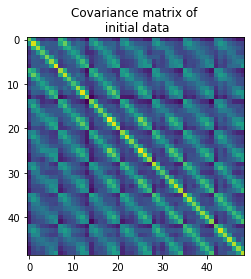

In [14]:
plt.figure(figsize = (4,4))
plt.title("Covariance matrix of \n initial data")
plt.imshow(Cov)

In [10]:
D, V = np.linalg.eig(Cov)
mD = np.diag(D)

In [11]:
Xw = X @ V @ np.linalg.inv(np.sqrt(mD)) @ V.T

In [12]:
wCov = np.cov(Xw.T)

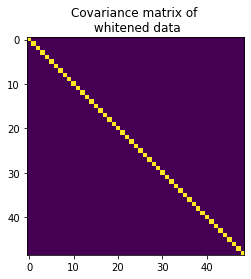

In [13]:
plt.figure(figsize = (4,4))
plt.title("Covariance matrix of \n whitened data")
plt.imshow(wCov)

### Look at higher-order statistical structure

In [16]:
def spawn_random_vector(l):
#     np.random.seed(10)
    w = np.reshape(np.random.rand(l), (l,1))
    w /= np.linalg.norm(w)
    return w

In [17]:
def g(v):
    return np.tanh(v)

In [18]:
def gprime(v):
    return 1-np.tanh(v)**2

#### 1) single component extraction

In [19]:
n_vector = 10
n_iter = 100
w_final = np.empty((n_vector, d*d, 1))
f = np.empty((n_vector, n_iter))
for v in range(n_vector):
    w = spawn_random_vector(d*d)
    for n in range(n_iter):
        f[v,n] = -np.log(np.cosh(Xw @ w)).mean()
        w_plus = (Xw.T @ g(w.T @ Xw.T).T - np.sum(gprime(w.T @ Xw.T))*w) / Xw.shape[0]
        w = w_plus / np.linalg.norm(w_plus)
    w_final[v] = w

Text(0.5, 1.0, 'Maximisation of f (random w draw)')

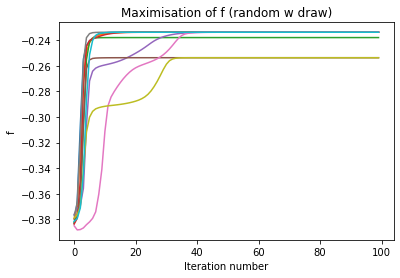

In [20]:
plt.figure(figsize = (6,4))
for v in range(n_vector):
    plt.plot(f[v])
plt.xlabel('Iteration number')
plt.ylabel('f')
plt.title('Maximisation of f (random w draw)')

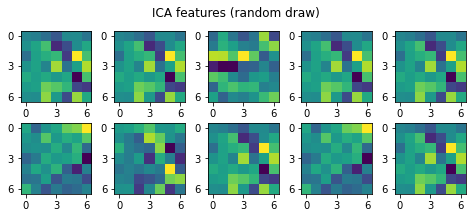

In [21]:
fig, ax = plt.subplots(2, int(n_vector/2), figsize = (8,3))
plt.suptitle('ICA features (random draw)', y = 0.99)
for i in range(n_vector):
    ax[i//int(n_vector/2)][i%int(n_vector/2)].imshow(np.reshape(w_final[i], (d, d)))
    ax[i//int(n_vector/2)][i%int(n_vector/2)].set_xticks([0,3,6])
    ax[i//int(n_vector/2)][i%int(n_vector/2)].set_yticks([0,3,6])
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

#### 2) multiple components extraction

In [24]:
n_vector = 49
n_iter = 500
wo_final = np.empty((n_vector, d*d, 1))
f = np.empty((n_vector, n_iter))
for p in range(n_vector):
    w = spawn_random_vector(d*d)
    for n in range(n_iter):
        f[p,n] = -np.log(np.cosh(Xw @ w)).mean()
        w_p = (Xw.T @ g(w.T @ Xw.T).T - np.sum(gprime(w.T @ Xw.T))*w) / Xw.shape[0]
        if p == 0:
            w = w_p / np.linalg.norm(w_p)
        else:
            wp_sum = [wo_final[i] @ (w_p.T @ wo_final[i]) for i in range(p-1)]
            wo_p = w_p - np.sum(wp_sum, axis = 0)
            w = wo_p / np.linalg.norm(wo_p)
    wo_final[p] = w
    

In [36]:
n_vector = 49
n_iter = 100
wo_final = np.empty((n_vector, d*d, 1))
f = np.empty((n_vector, n_iter))
for p in range(n_vector):
    w = spawn_random_vector(d*d)
    for n in range(n_iter):
        f[p,n] = -np.log(np.cosh(Xw @ w)).mean()
        w_p = (Xw.T @ g(w.T @ Xw.T).T - np.sum(gprime(w.T @ Xw.T))*w) / Xw.shape[0]
        w = w_p / np.linalg.norm(w_p)
    if p == 0:
        w_fin = w
    else:
        w_sum = [wo_final[i] @ (w.T @ wo_final[i]) for i in range(p-1)]
        wo_p = w - np.sum(w_sum, axis = 0)
        w_fin = wo_p / np.linalg.norm(wo_p)
    wo_final[p] = w_fin

Text(0.5, 1.0, 'Maximisation of f (random w draw)')

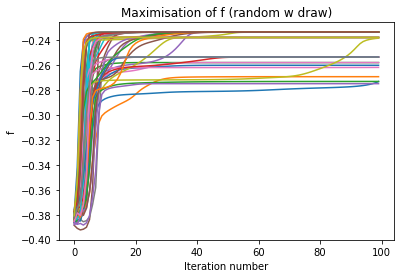

In [37]:
plt.figure(figsize = (6,4))
for v in range(n_vector):
    plt.plot(f[v])
plt.xlabel('Iteration number')
plt.ylabel('f')
plt.title('Maximisation of f (random w draw)')

In [38]:
wo_final.shape

(49, 49, 1)

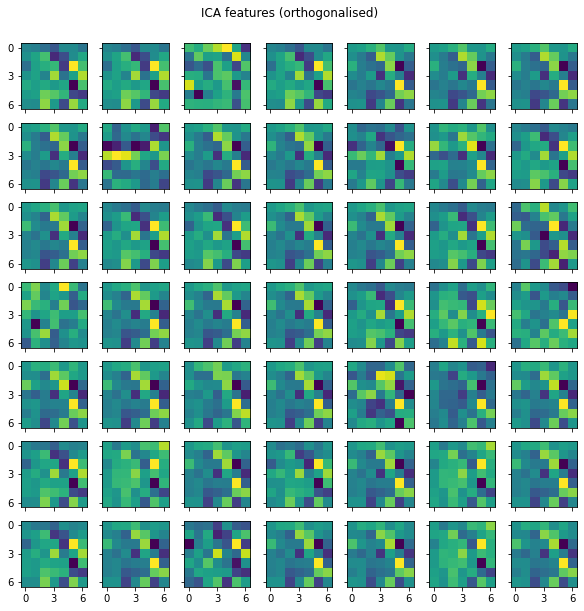

In [39]:
# fig, ax = plt.subplots(2, int(n_vector/2), figsize = (8,3))
fig, ax = plt.subplots(d, d, figsize = (10,10), sharex = True, sharey = True)
plt.suptitle('ICA features (orthogonalised)', y = 0.93)
for i in range(n_vector):
    ax[i//d][i%d].imshow(np.reshape(wo_final[i], (d, d)))
    ax[i//d][i%d].set_xticks([0,3,6])
    ax[i//d][i%d].set_yticks([0,3,6])
# fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

#### 3) sklearn trial

In [80]:
fastica = FastICA(n_components=49, whiten = False, fun = 'logcosh', max_iter = 5000)
fastica.fit(Xw)
w_pred = fastica.components_

/Users/ekaterinamaksimova/Programs/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:462: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')


In [81]:
w_pred.shape

(49, 49)

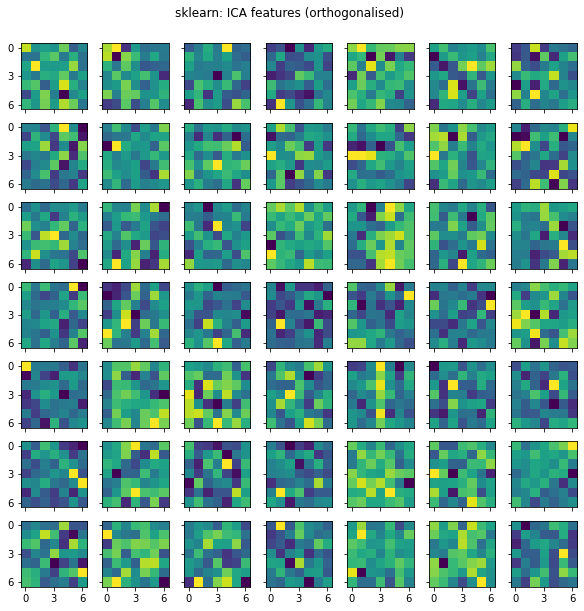

In [82]:
fig, ax = plt.subplots(d, d, figsize = (10,10), sharex = True, sharey = True)
plt.suptitle('sklearn: ICA features (orthogonalised)', y = 0.93)
for i in range(n_vector):
    ax[i//d][i%d].imshow(np.reshape(w_pred[i], (d, d)))
    ax[i//d][i%d].set_xticks([0,3,6])
    ax[i//d][i%d].set_yticks([0,3,6])